# AEFIT

This would be the first attempt to run the unsupervised learning VAE network to learn how to characterize a 1D profile with atted noise and missing input.

More than a simple fit, this method should learn 

In [1]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt

%aimport Dummy_g1data

import Dummy_g1data as dummy

%aimport models.base
%aimport models.AEFIT
%aimport models.AEFIT5
# ipysh.Bootstrap_support.debug()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


## Data and Model
The model and data generator are set:
Dummy data generator generates from a set of 5 kind of curves with a dataset cardinality of 60K samples.

All the shapes are generated from a dictionary array that defines mean sigma and gain of sum of gaussians.
This table is printed from the variable ds.kinds

>NOTE: 
> The actual model is generating random so it is not redoing the very same samples on each epoch.
> To exactly constraint the maximum size of the dataset the tf buffer can be used

the model uses bby default an input of 40 samples that are the (x,y) tuple values of 20 points from the generated shapes.


In [2]:
ds = dummy.Dummy_g1data(counts=10000).buffer()
ds.kinds

[{'gain': [1, 1], 'mean': [0.2, 0.8], 'sigma': [0.1, 0.1]},
 {'gain': [0.5], 'mean': [0.8], 'sigma': [0.1]},
 {'gain': [0.5], 'mean': [0.2], 'sigma': [0.1]},
 {'gain': [1], 'mean': [0.5], 'sigma': [0.2]},
 {'gain': [0.5], 'mean': [0.5], 'sigma': [0.2]}]

In [ ]:
# m = aefit.AEFIT(latent_dim=2)
# aefit.test_dummy(m, data=ds, epoch=5, batch=200, loss_factor=1e-3)

In [3]:
dds = ds.ds_array.map(lambda xy,l: (xy,xy) )
# [x for x in dds.take(1)][0]

W0916 16:47:06.611423 139744454276928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:505: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [75]:
m3 = models.AEFIT5.AEFIT5(latent_dim=2, scale=1, beta=0., geometry=[20,20,10,10])

AEFIT5 a ready:


In [76]:
# models.base.train(m3, ds, epoch=1, batch=200, learning_rate=1e-3)
m3.beta.assign(0.0005)
m3.fit(dds.skip(3000).batch(100, drop_remainder=True), validation_data=dds.take(3000).batch(100), epochs=39, shuffle=False)
# models.base.train_thread(m3, ds, epoch=10, batch=200, learning_rate=1e-3).control_panel()
# m3.train(ds, epoch=10)

Epoch 1/39
70/70 [==============================] - 4s 60ms/step - loss: 0.0611 - val_loss: 0.0000e+00
Epoch 2/39
70/70 [==============================] - 3s 38ms/step - loss: 0.0230 - val_loss: 0.0173
Epoch 3/39
70/70 [==============================] - 3s 38ms/step - loss: 0.0152 - val_loss: 0.0133
Epoch 4/39
70/70 [==============================] - 3s 39ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 5/39
70/70 [==============================] - 3s 37ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 6/39
70/70 [==============================] - 3s 37ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 7/39
70/70 [==============================] - 3s 39ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 8/39
70/70 [==============================] - 3s 38ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 9/39
70/70 [==============================] - 3s 37ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 10/39
70/70 [==============================] - 3s 37ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch

KeyboardInterrupt: 

In [77]:
p = Hplt.LSPlotBokeh()
p.set_model(m3)
p.set_data(ds, counts=1000)
p.plot(notebook_url='http://172.17.0.2:8888')

Loading BokehJS ...

In [ ]:
relevance = m3.generative_net.layers[0]
relevance.weights

## Missing data simulation

Now we want to test the network against particular shapes within the latent main paths but with added noise and simulated missing data. The function simulate_missing_data reduce de number of available input simply duplicating the point that precedes the missing one with the same value.

A further gaussian noise has been also applied.

In [56]:

def simulate_missing_data(m, lpt=[0.5,-1.6], noise_var=0.05, arr = []):
    xy = m.decode(tf.convert_to_tensor([pt]), training=False)
    x,y = tf.split(xy[0], 2)
    x,y = (x.numpy(), y.numpy())

    fig = plt.figure('gen_missing_curve',figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)    
    
    ax1.set_xlim(-2.,2.)
    ax1.set_ylim(-2.,2.)
    
    ax1.scatter(pt[0],pt[1],s=80)
    ax2.scatter(x,y,s=40)

    # apply noise
    x += np.random.normal(0,noise_var,len(x))
    y += np.random.normal(0,noise_var,len(y))

    # apply missing data simulation
    for i,v in enumerate(arr,0):
        x[arr[i]]=x[arr[i]+1]
        y[arr[i]]=y[arr[i]+1]
    
    ax2.scatter(x,y,s=80)

    me,va = m.encode(tf.reshape(tf.concat([x,y],0), shape=[1,-1]), training=False)
    print("Guessed Latent point = ",me.numpy())
    gpt = me[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = m.decode(me, training=False)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())
    # plt.figure('reconstructed')
    ax2.scatter(X,Y,s=40)
    # plt.plot(X,Y)



We start by generating close to the shape {'mean': [0.5], 'sigma': [0.2], 'gain': [0.5]}

This is in the middle of the central cluster

Guessed Latent point =  [[-0.39418045  0.02416418]]


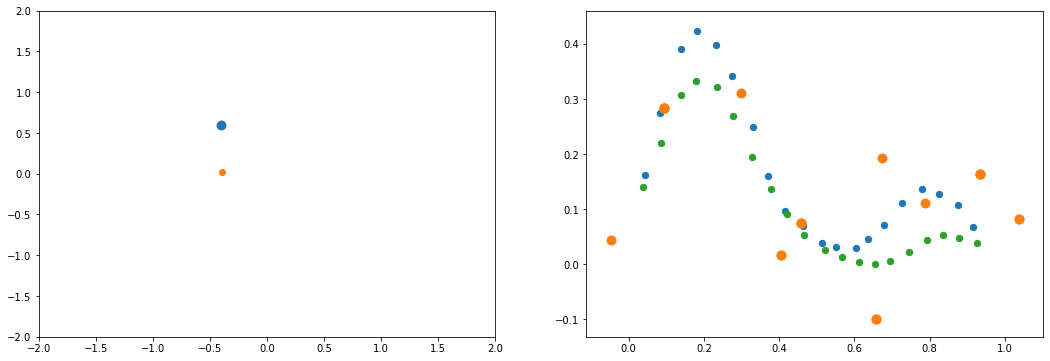

In [48]:
# generate from point: 0.6, -0.7
pt = [-0.400,0.593]
noise_var = 0.1
arr = [3,2,1,5,8,7,6,9,12,11,14,13,18]
simulate_missing_data(m3, pt,noise_var,arr)


Now we want to check if the nework can simulate a point in the middle od two clusters

Guessed Latent point =  [[0.83593065 0.1198338 ]]


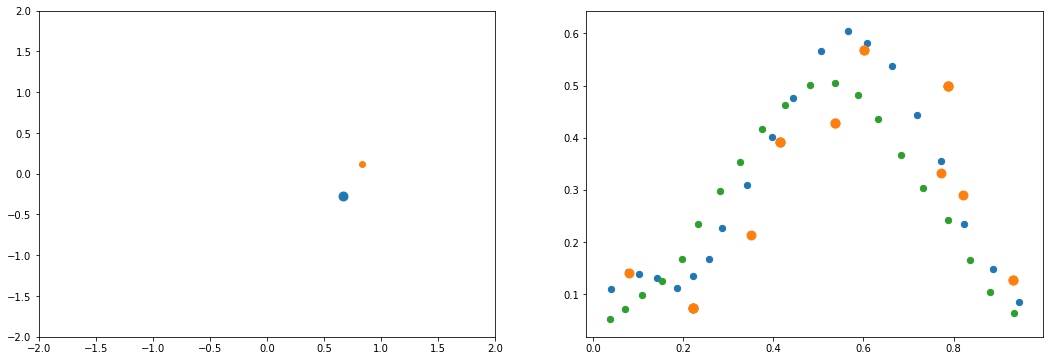

In [66]:
# generate from point: 0.5, -1.6
pt = [0.666,-0.278]
noise_var = 0.05
arr = [3,2,1,5,8,7,6,9,12,11,14,13,18]
simulate_missing_data(m3, pt,noise_var,arr)



Guessed Latent point =  [[-0.70846456  0.6355695 ]]


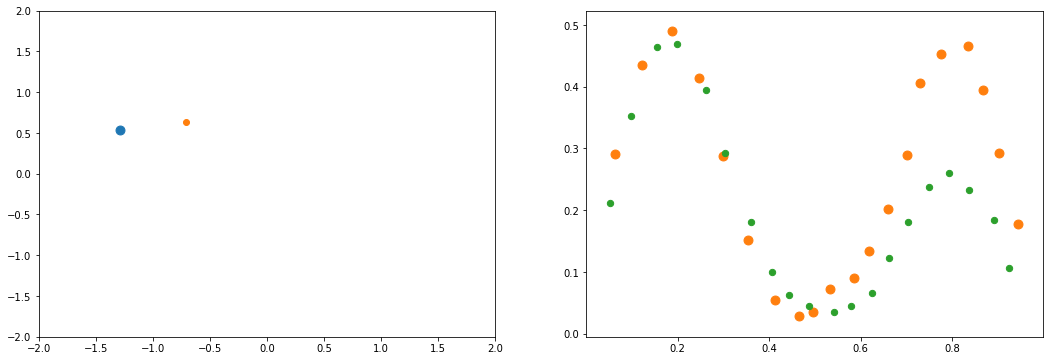

In [58]:
# generate from point: 0.5, -1.6
pt = [-1.283,0.541]
noise_var = 0.0
#arr = [3,2,1,5,8,7,6,9,12,11,14,13,18]
simulate_missing_data(m3, pt,noise_var)

